<a href="https://colab.research.google.com/github/Nvoinxv/machinelearnnvoin/blob/main/Analisis_Kualitas_Udara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Import libary

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2.Import data
gw akan lebih fokus di tipe_kota_data

In [110]:
tipe_kota_data = pd.read_csv("/content/drive/MyDrive/analisa sentiment kualitas udara industri perumahan/City_Types.csv")
tipe_kota_data

,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,Type
0,2024-01-01 00:00:00+00:00,Moscow,208.0,15.9,13.2,44.0,8.6,9.4,Industrial
1,2024-01-01 01:00:00+00:00,Moscow,207.0,17.4,13.7,44.0,8.6,10.5,Industrial
2,2024-01-01 02:00:00+00:00,Moscow,217.0,19.0,15.5,43.0,10.4,12.9,Industrial
3,2024-01-01 03:00:00+00:00,Moscow,231.0,21.0,20.7,36.0,12.3,15.3,Industrial
4,2024-01-01 04:00:00+00:00,Moscow,263.0,34.5,27.2,27.0,13.6,20.0,Industrial
...,...,...,...,...,...,...,...,...,...
52699,2024-12-31 19:00:00+00:00,Stockholm,211.0,20.5,1.1,54.0,4.6,10.6,Residential
52700,2024-12-31 20:00:00+00:00,Stockholm,183.0,10.0,0.6,64.0,2.5,6.0,Residential
52701,2024-12-31 21:00:00+00:00,Stockholm,167.0,5.1,0.4,72.0,2.0,4.4,Residential
52702,2024-12-31 22:00:00+00:00,Stockholm,160.0,3.9,0.3,73.0,1.4,2.6,Residential


In [111]:
tipe_kota_data = tipe_kota_data.drop(columns="Date")

In [112]:
tipe_kota_data.columns

Index(['City', 'CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'Type'], dtype='object')

In [113]:
tipe_kota_data.dtypes

,0
City,object
CO,float64
NO2,float64
SO2,float64
O3,float64
PM2.5,float64
PM10,float64
Type,object


In [114]:
tipe_kota_data_original = tipe_kota_data.copy()

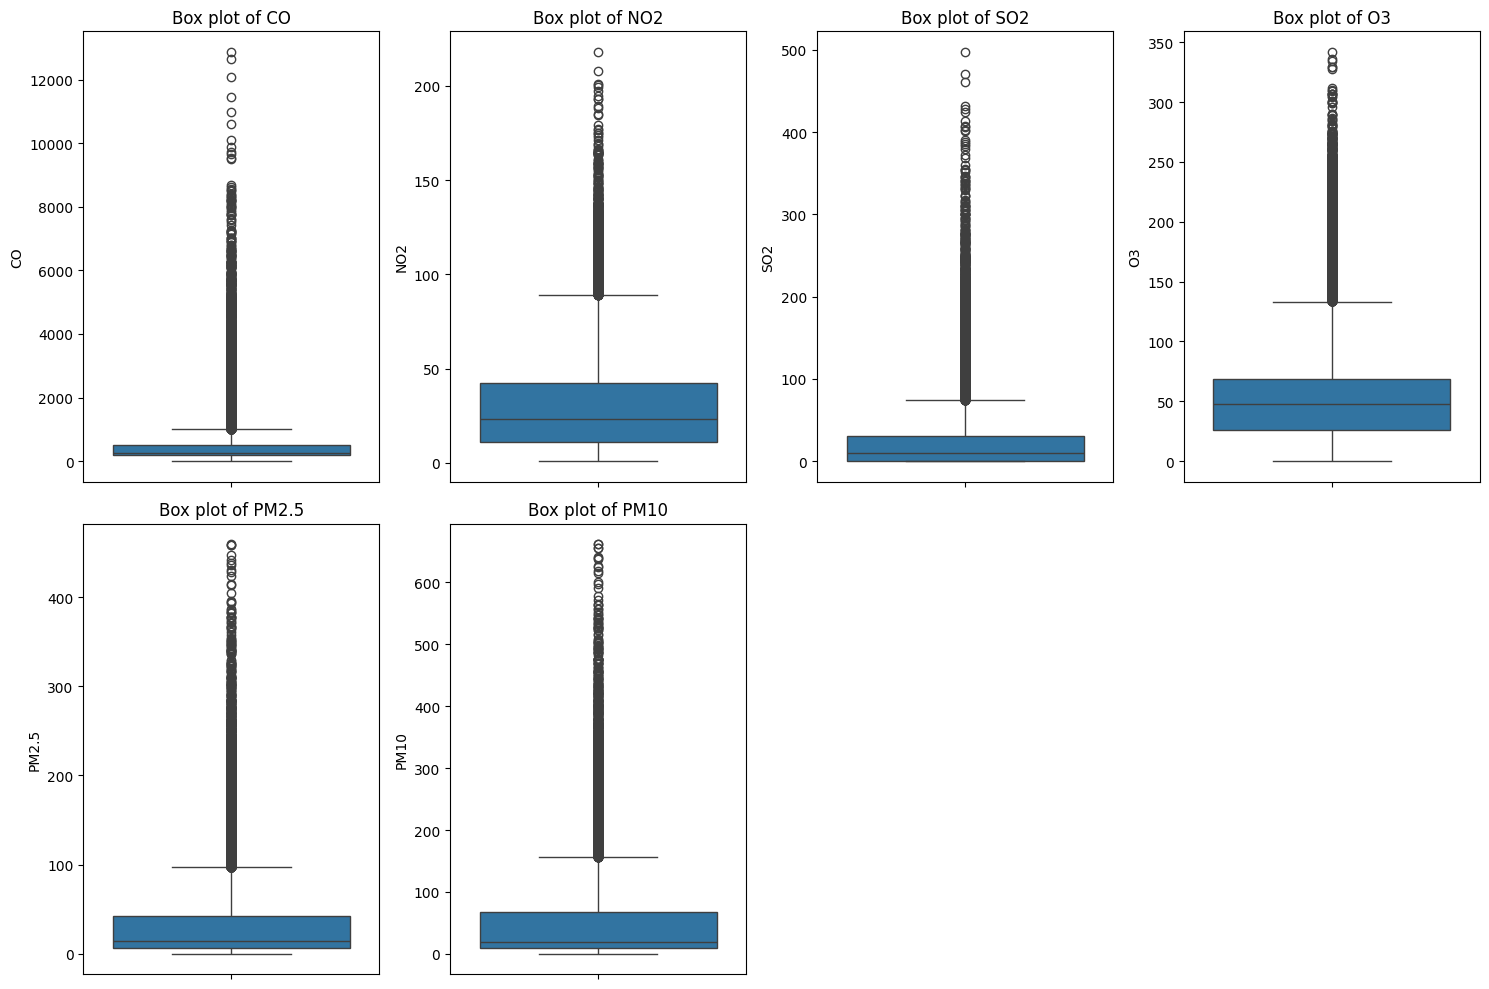

In [115]:
numeric_cols = tipe_kota_data.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(y=tipe_kota_data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

In [116]:
numeric_cols = tipe_kota_data.select_dtypes(include=np.number).columns

Q1 = tipe_kota_data[numeric_cols].quantile(0.25)
Q3 = tipe_kota_data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

tipe_kota_data_cleaned = tipe_kota_data.copy()
for col in numeric_cols:
    tipe_kota_data_cleaned = tipe_kota_data_cleaned[(tipe_kota_data_cleaned[col] >= lower_bound[col]) & (tipe_kota_data_cleaned[col] <= upper_bound[col])]

print("Original data shape:", tipe_kota_data.shape)
print("Cleaned data shape:", tipe_kota_data_cleaned.shape)

Original data shape: (52704, 8)
Cleaned data shape: (42222, 8)


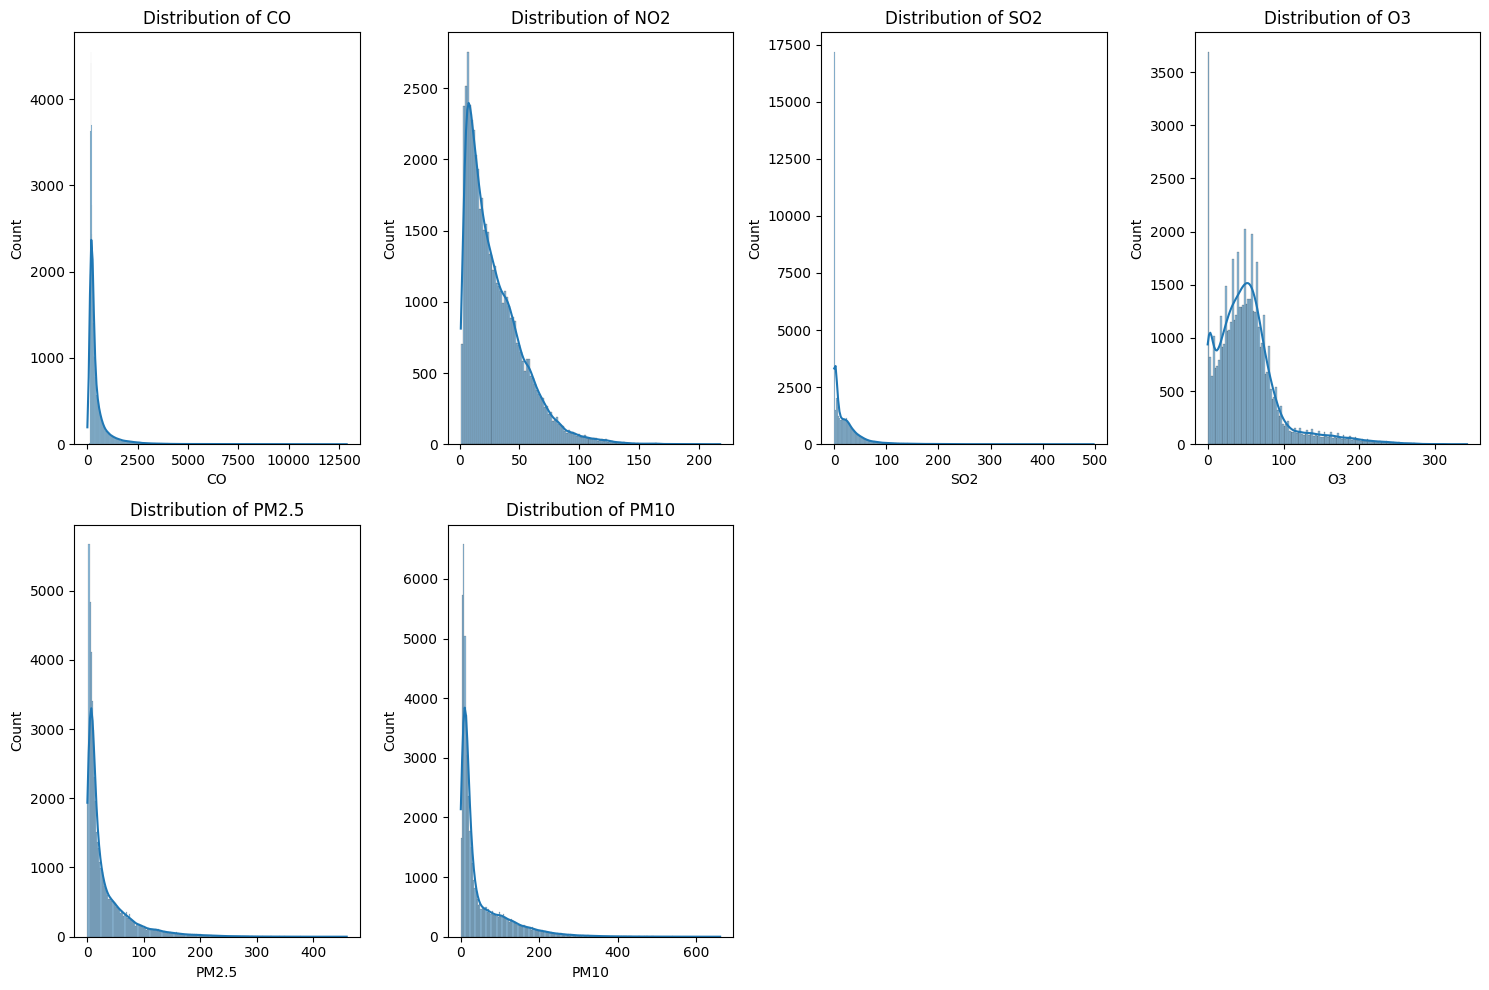

In [117]:
numeric_cols = tipe_kota_data_cleaned.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=tipe_kota_data, x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [118]:
tipe_kota_data_cleaned.isnull().sum()

,0
City,0
CO,0
NO2,0
SO2,0
O3,0
PM2.5,0
PM10,0
Type,0


In [119]:
label_encoder = LabelEncoder()
tipe_kota_data_cleaned['City_encoded'] = label_encoder.fit_transform(tipe_kota_data_cleaned['City'])
tipe_kota_data_cleaned['Type_encoded'] = label_encoder.fit_transform(tipe_kota_data_cleaned['Type'])
print(tipe_kota_data_cleaned[['City', 'City_encoded', 'Type', 'Type_encoded']].head())

     City  City_encoded        Type  Type_encoded
0  Moscow             2  Industrial             0
1  Moscow             2  Industrial             0
2  Moscow             2  Industrial             0
3  Moscow             2  Industrial             0
4  Moscow             2  Industrial             0


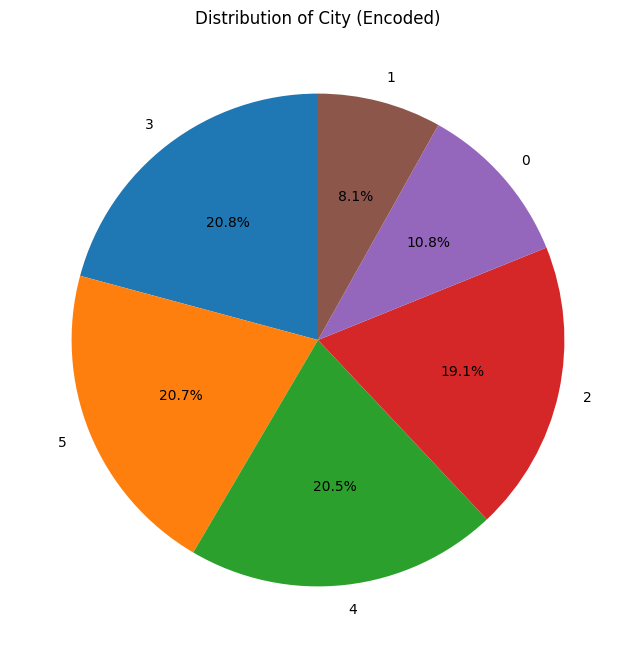

In [120]:
city_distribution = tipe_kota_data_cleaned['City_encoded'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(city_distribution, labels=city_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of City (Encoded)')
plt.show()

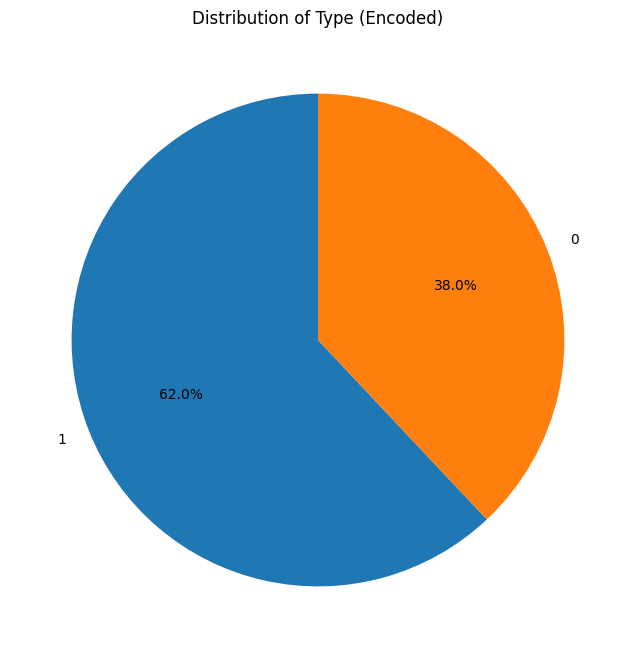

In [121]:
type_distribution = tipe_kota_data_cleaned['Type_encoded'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(type_distribution, labels=type_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Type (Encoded)')
plt.show()

In [122]:
MinMax = MinMaxScaler(feature_range=(0,1))
cols_to_scale = ["CO", "NO2", "SO2", "O3", "PM2.5", "PM10"]
tipe_kota_data_cleaned[cols_to_scale] = MinMax.fit_transform(tipe_kota_data_cleaned[cols_to_scale])

In [123]:
tipe_kota_data_cleaned = tipe_kota_data_cleaned.drop(columns=["City"])
tipe_kota_data_cleaned = tipe_kota_data_cleaned.drop(columns=["Type"])

In [124]:
tipe_kota_data_cleaned

,CO,NO2,SO2,O3,PM2.5,PM10,City_encoded,Type_encoded
0,0.149317,0.169318,0.177419,0.330827,0.085921,0.057655,2,0
1,0.148265,0.186364,0.184140,0.330827,0.085921,0.064702,2,0
2,0.158780,0.204545,0.208333,0.323308,0.104555,0.080077,2,0
3,0.173502,0.227273,0.278226,0.270677,0.124224,0.095452,2,0
4,0.207150,0.380682,0.365591,0.203008,0.137681,0.125561,2,0
...,...,...,...,...,...,...,...,...
52699,0.152471,0.221591,0.014785,0.406015,0.044513,0.065343,3,1
52700,0.123028,0.102273,0.008065,0.481203,0.022774,0.035874,3,1
52701,0.106204,0.046591,0.005376,0.541353,0.017598,0.025625,3,1
52702,0.098843,0.032955,0.004032,0.548872,0.011387,0.014094,3,1


3.Proses training data tipe_kota dengan scikit learn

In [125]:
X_tipe_kota = tipe_kota_data_cleaned.drop(columns=["Type_encoded"])
y_tipe_kota = tipe_kota_data_cleaned["Type_encoded"]

X_train_kota, X_test_kota, y_train_kota, y_test_kota = train_test_split(X_tipe_kota, y_tipe_kota, test_size=0.2, random_state=42)

In [126]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_kota, y_train_kota)
print("Shape of X_train before SMOTE:", X_train_kota.shape)
print("Shape of X_train after SMOTE:", X_train_resampled.shape)
print("Shape of y_train before SMOTE:", y_train_kota.shape)
print("Shape of y_train after SMOTE:", y_train_resampled.shape)
print("\nDistribution of y_train before SMOTE:\n", y_train_kota.value_counts())
print("\nDistribution of y_train after SMOTE:\n", y_train_resampled.value_counts())

Shape of X_train before SMOTE: (33777, 7)
Shape of X_train after SMOTE: (41948, 7)
Shape of y_train before SMOTE: (33777,)
Shape of y_train after SMOTE: (41948,)

Distribution of y_train before SMOTE:
 Type_encoded
1    20974
0    12803
Name: count, dtype: int64

Distribution of y_train after SMOTE:
 Type_encoded
0    20974
1    20974
Name: count, dtype: int64


In [127]:
model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_1.fit(X_train_kota, y_train_kota)
y_pred_kota_model_1 = model_1.predict(X_test_kota)

In [128]:
model_2 = DecisionTreeClassifier(random_state=42)
model_2.fit(X_train_kota, y_train_kota)
y_pred_kota_model_2 = model_2.predict(X_test_kota)

In [129]:
model_3 = GaussianNB()
model_3.fit(X_train_kota, y_train_kota)
y_pred_kota_model_3 = model_3.predict(X_test_kota)

4.Evaluasi setiap model klasifikasi dari ensemble, tree, dan navies

In [130]:
accuracy_1 = accuracy_score(y_test_kota, y_pred_kota_model_1)
accuracy_2 = accuracy_score(y_test_kota, y_pred_kota_model_2)
accuracy_3 = accuracy_score(y_test_kota, y_pred_kota_model_3)

print(f"Akurasi model random forest: {accuracy_1}")
print(f"Akurasi model decision tree: {accuracy_2}")
print(f"Akurasi model naive bayes: {accuracy_3}")

Akurasi model random forest: 1.0
Akurasi model decision tree: 1.0
Akurasi model naive bayes: 0.9570159857904085


In [131]:
classification_1 = classification_report(y_test_kota, y_pred_kota_model_1)
classification_2 = classification_report(y_test_kota, y_pred_kota_model_2)
classification_3 = classification_report(y_test_kota, y_pred_kota_model_3)

print(f"Laporan klasifikasi model random forest:\n{classification_1}")
print(f"Laporan klasifikasi model decision tree:\n{classification_2}")
print(f"Laporan klasifikasi model naive bayes:\n{classification_3}")

Laporan klasifikasi model random forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3234
           1       1.00      1.00      1.00      5211

    accuracy                           1.00      8445
   macro avg       1.00      1.00      1.00      8445
weighted avg       1.00      1.00      1.00      8445

Laporan klasifikasi model decision tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3234
           1       1.00      1.00      1.00      5211

    accuracy                           1.00      8445
   macro avg       1.00      1.00      1.00      8445
weighted avg       1.00      1.00      1.00      8445

Laporan klasifikasi model naive bayes:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3234
           1       0.97      0.96      0.97      5211

    accuracy                           0.96      8445
   macr

In [132]:
confusion_1 = confusion_matrix(y_test_kota, y_pred_kota_model_1)
confusion_2 = confusion_matrix(y_test_kota, y_pred_kota_model_2)
confusion_3 = confusion_matrix(y_test_kota, y_pred_kota_model_3)

print(f"Confusion matrix model random forest:\n{confusion_1}")
print(f"Confusion matrix model decision tree:\n{confusion_2}")
print(f"Confusion matrix model naive bayes:\n{confusion_3}")

Confusion matrix model random forest:
[[3234    0]
 [   0 5211]]
Confusion matrix model decision tree:
[[3234    0]
 [   0 5211]]
Confusion matrix model naive bayes:
[[3056  178]
 [ 185 5026]]


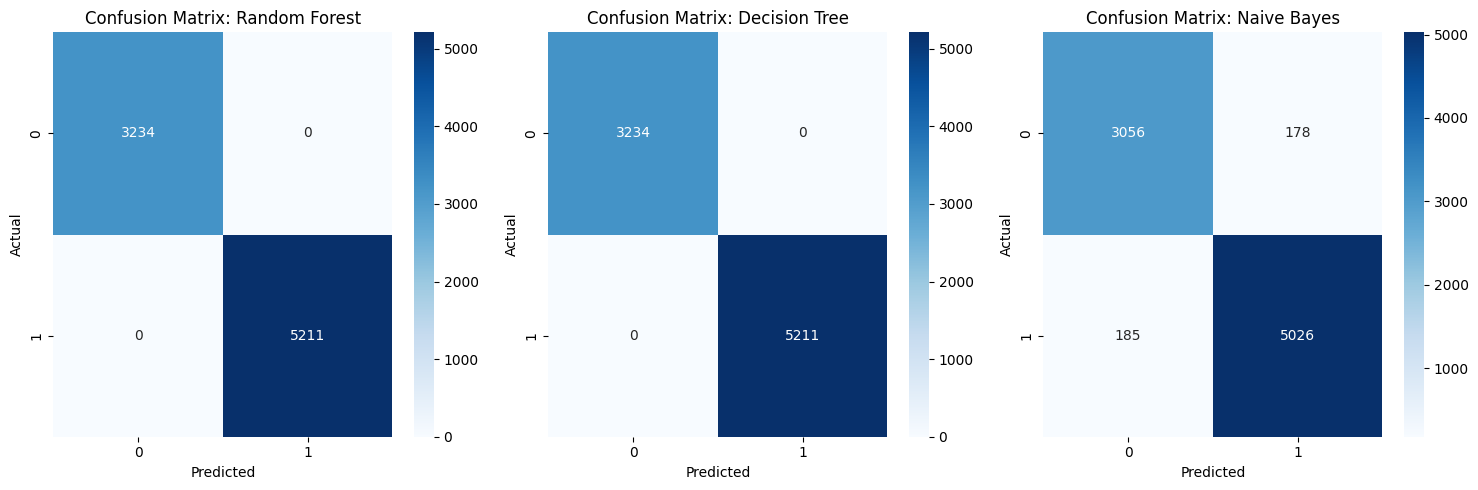

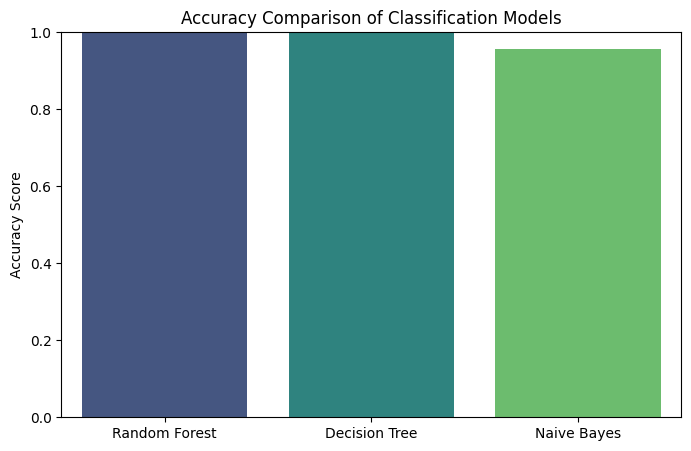

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix: Random Forest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix: Decision Tree')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(confusion_3, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix: Naive Bayes')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

models = ['Random Forest', 'Decision Tree', 'Naive Bayes']
accuracies = [accuracy_1, accuracy_2, accuracy_3]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Accuracy Comparison of Classification Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.show()

5.Saat nya gw fokus bagian data penyakit ini dengan pertama tama cleaning data dan preprocessing

In [134]:
data_penyakit = pd.read_csv("/content/drive/MyDrive/analisa sentiment kualitas udara industri perumahan/heart.csv")
data_penyakit

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [135]:
data_penyakit.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


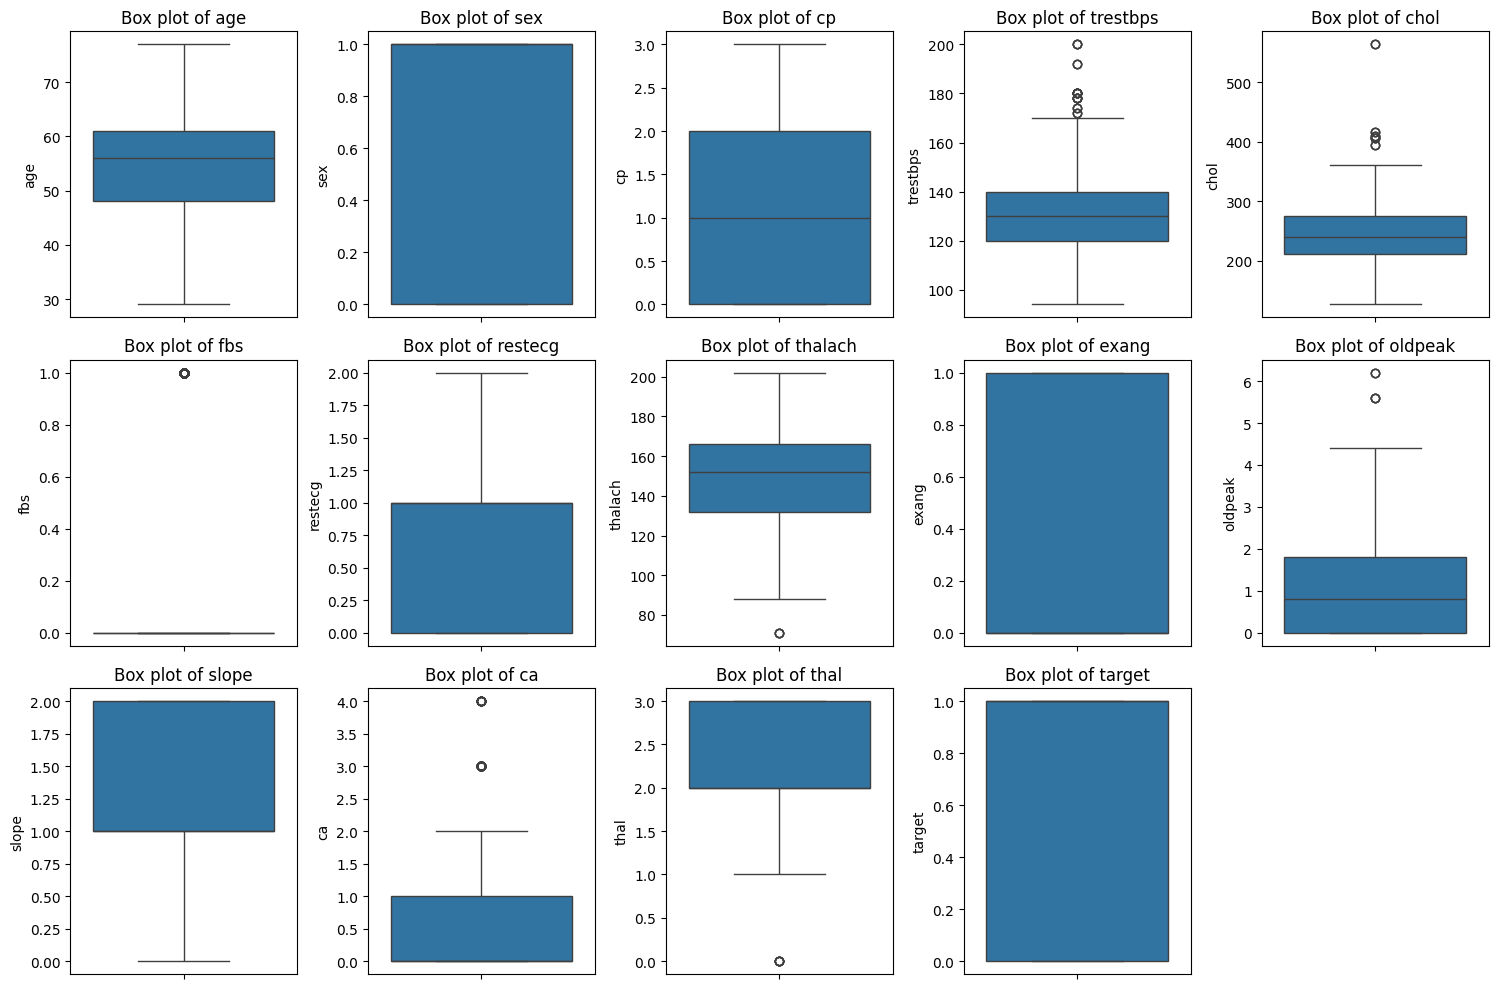

In [136]:
numeric_cols_penyakit = data_penyakit.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols_penyakit):
    plt.subplot(3, 5, i + 1)
    sns.boxplot(y=data_penyakit[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

In [137]:
data_penyakit_original = data_penyakit.copy()

In [138]:
numeric_cols = data_penyakit.select_dtypes(include=np.number).columns

Q1 = data_penyakit[numeric_cols].quantile(0.25)
Q3 = data_penyakit[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_penyakit_cleaned = data_penyakit.copy()
for col in numeric_cols:
    data_penyakit_cleaned = data_penyakit_cleaned[(data_penyakit_cleaned[col] >= lower_bound[col]) & (data_penyakit_cleaned[col] <= upper_bound[col])]

print("Original data shape:", data_penyakit.shape)
print("Cleaned data shape:", data_penyakit_cleaned.shape)

Original data shape: (1025, 14)
Cleaned data shape: (769, 14)


6.Tahap training data lagi

In [140]:
X_penyakit = data_penyakit_cleaned.drop(columns=["target"])
y_penyakit = data_penyakit_cleaned["target"]

X_train_penyakit, X_test_penyakit, y_train_penyakit, y_test_penyakit = train_test_split(X_penyakit, y_penyakit,
                                                                                        test_size=0.2, random_state=42)

In [141]:
model_penyakit_1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_penyakit_1.fit(X_train_penyakit, y_train_penyakit)
y_pred_penyakit_1 = model_penyakit_1.predict(X_test_penyakit)

In [142]:
model_penyakit_2 = DecisionTreeClassifier(random_state=42)
model_penyakit_2.fit(X_train_penyakit, y_train_penyakit)
y_pred_penyakit_2 = model_penyakit_2.predict(X_test_penyakit)

In [143]:
model_penyakit_3 = GaussianNB()
model_penyakit_3.fit(X_train_penyakit, y_train_penyakit)
y_pred_penyakit_3 = model_penyakit_3.predict(X_test_penyakit)

7.Tahap evaluasi model yang di latih

In [144]:
accuracy_penyakit_1 = accuracy_score(y_test_penyakit, y_pred_penyakit_1)
accuracy_penyakit_2 = accuracy_score(y_test_penyakit, y_pred_penyakit_2)
accuracy_penyakit_3 = accuracy_score(y_test_penyakit, y_pred_penyakit_3)

print(f"Akurasi model penyakit Random Forest: {accuracy_penyakit_1}")
print(f"Akurasi model penyakit Decision Tree: {accuracy_penyakit_2}")
print(f"Akurasi model penyakit Naive Bayes: {accuracy_penyakit_3}")

classification_penyakit_1 = classification_report(y_test_penyakit, y_pred_penyakit_1)
classification_penyakit_2 = classification_report(y_test_penyakit, y_pred_penyakit_2)
classification_penyakit_3 = classification_report(y_test_penyakit, y_pred_penyakit_3)

print(f"Laporan klasifikasi model penyakit Random Forest:\n{classification_penyakit_1}")
print(f"Laporan klasifikasi model penyakit Decision Tree:\n{classification_penyakit_2}")
print(f"Laporan klasifikasi model penyakit Naive Bayes:\n{classification_penyakit_3}")

confusion_penyakit_1 = confusion_matrix(y_test_penyakit, y_pred_penyakit_1)
confusion_penyakit_2 = confusion_matrix(y_test_penyakit, y_pred_penyakit_2)
confusion_penyakit_3 = confusion_matrix(y_test_penyakit, y_pred_penyakit_3)

print(f"Confusion matrix model penyakit Random Forest:\n{confusion_penyakit_1}")
print(f"Confusion matrix model penyakit Decision Tree:\n{confusion_penyakit_2}")
print(f"Confusion matrix model penyakit Naive Bayes:\n{confusion_penyakit_3}")

Akurasi model penyakit Random Forest: 1.0
Akurasi model penyakit Decision Tree: 1.0
Akurasi model penyakit Naive Bayes: 0.7987012987012987
Laporan klasifikasi model penyakit Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        90

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154

Laporan klasifikasi model penyakit Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        90

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154

Laporan klasifikasi model penyakit Naive Bayes:
              precision    recall  f1-score   support

    

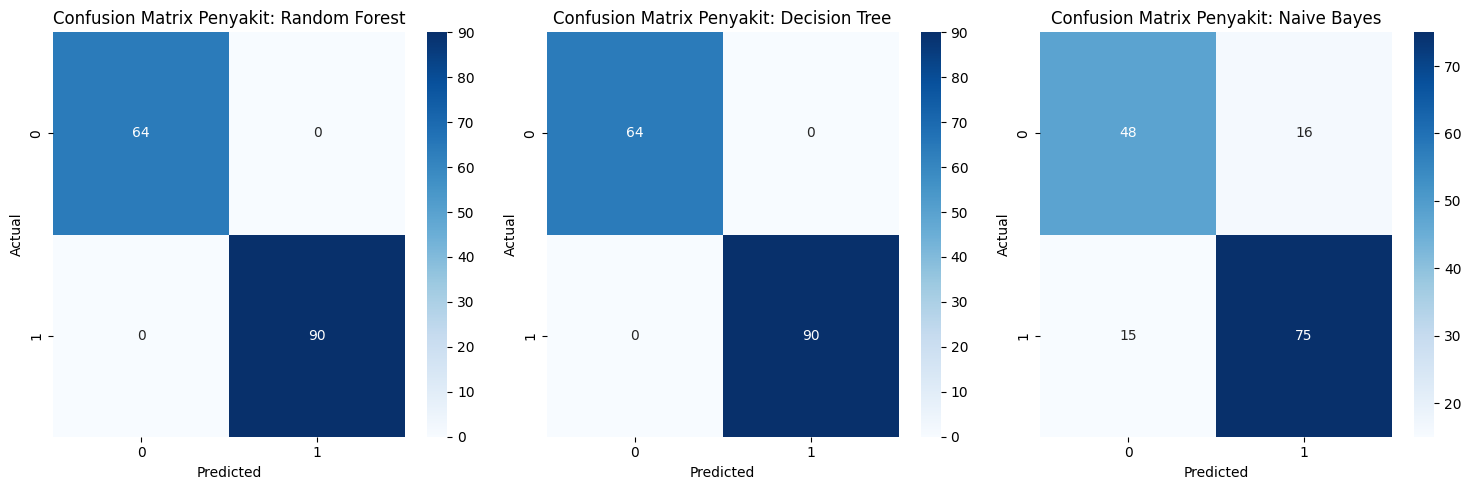

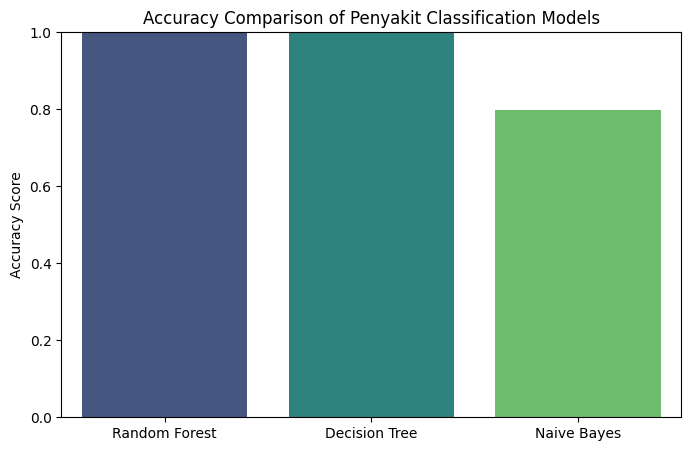

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_penyakit_1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix Penyakit: Random Forest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_penyakit_2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix Penyakit: Decision Tree')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(confusion_penyakit_3, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix Penyakit: Naive Bayes')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

models_penyakit = ['Random Forest', 'Decision Tree', 'Naive Bayes']
accuracies_penyakit = [accuracy_penyakit_1, accuracy_penyakit_2, accuracy_penyakit_3]

plt.figure(figsize=(8, 5))
sns.barplot(x=models_penyakit, y=accuracies_penyakit, palette='viridis')
plt.title('Accuracy Comparison of Penyakit Classification Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.show()